In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score



In [2]:
from torchsummary import summary


In [3]:
class DummyDataset(Dataset):
    def __init__(self, fpath) -> None:
        super().__init__()
        try:
            data = pd.read_csv(fpath).drop("cluster", axis=1).values
        except KeyError:
            data = pd.read_csv(fpath).values
        self.data = torch.Tensor(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index) -> tuple:
        return self.data[index, 1:], self.data[index, 0]


In [4]:
class MultiExpertModel(nn.Module):
    def __init__(self, input_dim, num_expert) -> None:
        super().__init__()
        self.expert_weight = nn.Linear(in_features=input_dim, out_features=num_expert)
        self.experts_scores = nn.Linear(in_features=input_dim, out_features=num_expert)

    def forward(self, x):
        w = F.softmax(self.expert_weight(x), dim=1) # TODO: can add sparsity
        expert_scores = F.sigmoid(self.experts_scores(x))
        # return F.sigmoid(torch.sum(w * expert_scores, dim=1))
        return torch.sum(w * expert_scores, dim=1)

    def evaluate(self, dataloader, criterion):
        total_loss = 0.0
        total_sample = 0.0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(dataloader):
                p_batch = self(X_batch)
                total_loss += criterion(p_batch, y_batch).item()
                total_sample += X_batch.shape[0]
        return total_loss / total_sample


In [5]:
train = DummyDataset("./train.csv") # sigma = 0.2
test = DummyDataset("./test.csv")

train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=True)


In [6]:
train.data[:1000, 1].std()


tensor(0.2034)

In [29]:
model = MultiExpertModel(input_dim=train.data.shape[1] - 1, num_expert=6)
criterion = nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
for epoch in range(301):
    total_loss = 0.0
    total_sample = 0.0
    disable = epoch % 50 != 0
    with tqdm(train_dl, unit="batch", mininterval=0, disable=disable) as bar:
        bar.set_description(f"Epoch {epoch}")
        for X_batch, y_batch in bar:
            optimizer.zero_grad()
            p_batch = model(X_batch)
            loss = criterion(p_batch, y_batch)
            loss.backward()
            optimizer.step()
            # update progress bar
            total_loss += loss.item()
            total_sample += X_batch.shape[0]
            bar.set_postfix(ce=float(total_loss / total_sample))


Epoch 300: 100%|██████████| 50/50 [00:00<00:00, 244.24batch/s, ce=0.163]


In [30]:
roc_auc_score(
    y_true=test_dl.dataset.data[:, 0],
    y_score=model(test_dl.dataset.data[:, 1:]).detach(),
)


0.956627893981207

### test on catersian_prod & reshaping

In [40]:
xs = torch.linspace(start=-1, end=3, steps=3)
ys = torch.linspace(start=-1, end=3, steps=3)
torch.cartesian_prod(ys, xs)


tensor([[-1., -1.],
        [-1.,  1.],
        [-1.,  3.],
        [ 1., -1.],
        [ 1.,  1.],
        [ 1.,  3.],
        [ 3., -1.],
        [ 3.,  1.],
        [ 3.,  3.]])

In [41]:
torch.cartesian_prod(xs, ys)[:, 0].reshape(3, 3)


tensor([[-1., -1., -1.],
        [ 1.,  1.,  1.],
        [ 3.,  3.,  3.]])

In [36]:
torch.cartesian_prod(xs, ys)[:, 1].reshape(3, 3)


tensor([[-1.,  1.,  3.],
        [-1.,  1.,  3.],
        [-1.,  1.,  3.]])

### plot

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

plt.style.use("default")


In [13]:
def visualize_expert_decisions(model, lims, grid_n):
    xs = torch.linspace(start=lims[0], end=lims[1], steps=grid_n)
    ys = torch.linspace(start=lims[0], end=lims[1], steps=grid_n)
    ws = F.softmax(model.expert_weight(torch.cartesian_prod(ys, xs)), dim=1).detach()

    fig, axs = plt.subplots(1, ws.shape[1], sharey=True)
    for i in range(ws.shape[1]):
        im = axs[i].imshow(
            ws[:,i].reshape(grid_n, grid_n),
            extent=[lims[0], lims[1], lims[1], lims[0]],
            vmin=0, vmax=1
        )
        axs[i].invert_yaxis()
        
    fig.tight_layout(pad=1)
    plt.title("Weight distribution across experts")
    fig.colorbar(im, ax=axs, orientation='horizontal')
    plt.show()

    scores = F.sigmoid(model.experts_scores(torch.cartesian_prod(ys, xs))).detach()
    fig, axs = plt.subplots(1, scores.shape[1], sharey=True)
    for i in range(scores.shape[1]):
        im = axs[i].imshow(
            scores[:,i].reshape(grid_n, grid_n),
            extent=[lims[0], lims[1], lims[1], lims[0]],
            vmin=0, vmax=1
        )
        axs[i].invert_yaxis()

    fig.tight_layout(pad=1)
    fig.colorbar(im, ax=axs.ravel(), orientation='horizontal')
    plt.title("Score distribution across experts")
    plt.show()

    p = model(torch.cartesian_prod(ys, xs)).detach()
    fig, ax = plt.subplots()
    im = ax.imshow(
        p.reshape(grid_n, grid_n),
        extent=[lims[0], lims[1], lims[1], lims[0]],
        vmin=0, vmax=1
    )
    ax.invert_yaxis()
    fig.colorbar(im, ax=ax, orientation='horizontal')
    plt.title("Aggregated decision")
    plt.show()


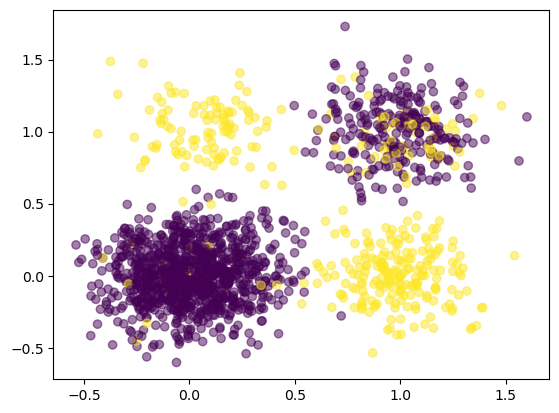

In [11]:
plt.scatter(
	x=train.data[:,1],
	y=train.data[:,2],
	c=train.data[:,0],
	alpha=0.5
)
plt.show()


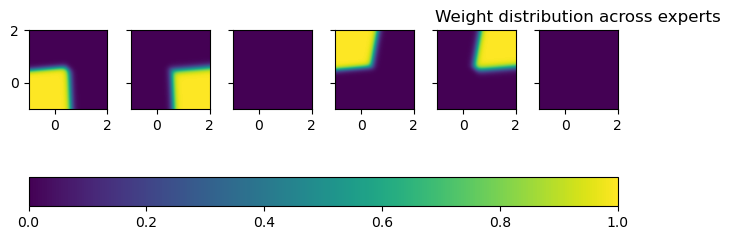

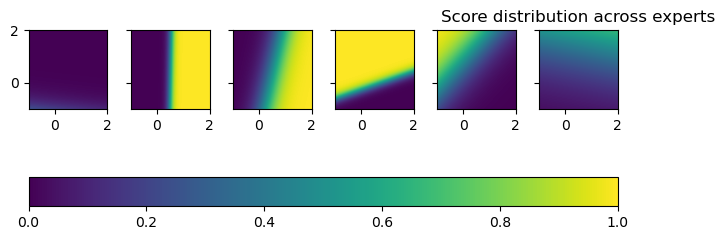

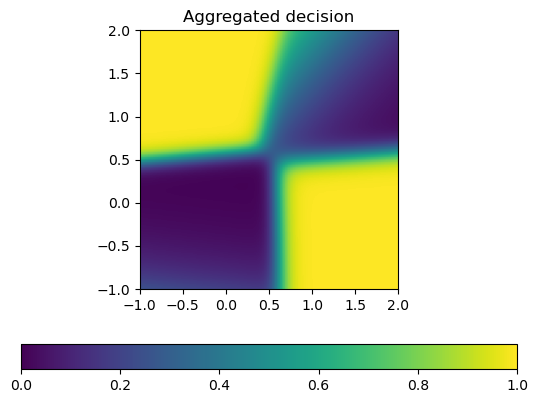

In [31]:
visualize_expert_decisions(model, (-1, 2), 100)


In [16]:
model(train.data[:,1:]).max()


tensor(0.9995, grad_fn=<MaxBackward1>)

In [60]:
F.sigmoid(torch.tensor(0))


tensor(0.5000)

# plots in scratch

In [17]:
plot_data = pd.DataFrame(
    {
        "phat": model(test_dl.dataset.data[:, 1:]).detach().numpy(),
        "y": test_dl.dataset.data[:, 0].numpy().astype("int").astype("str"),
		"cluster": pd.read_csv("./test.csv")["cluster"].values.astype("str")
    }
)
plot_data


,phat,y,cluster
0,0.025322,0,1
1,0.057804,0,1
2,0.005646,0,1
3,0.149999,0,1
4,0.003599,0,1
...,...,...,...
1595,0.112530,0,4
1596,0.112917,0,4
1597,0.114462,0,4
1598,0.283605,0,4


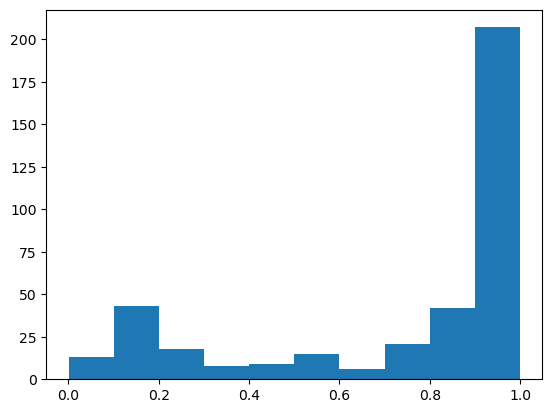

In [23]:
plt.hist(x=plot_data.loc[plot_data['y'] == "1"]["phat"].values)
plt.show()


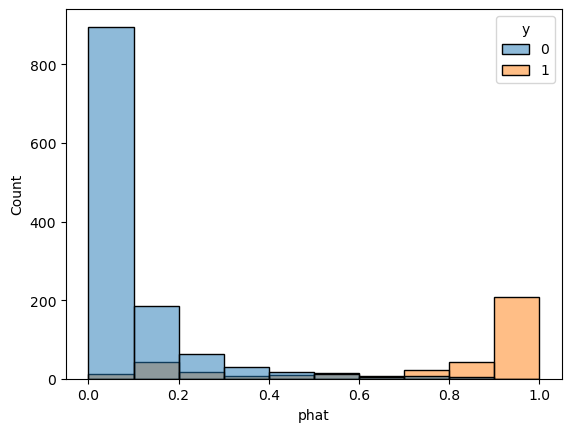

In [20]:
fig = sns.histplot(data=plot_data, x="phat", hue="y", binwidth=0.1, stat="count", palette=sns.color_palette("tab10", 2))
# fig.set_yscale("log")
plt.show()


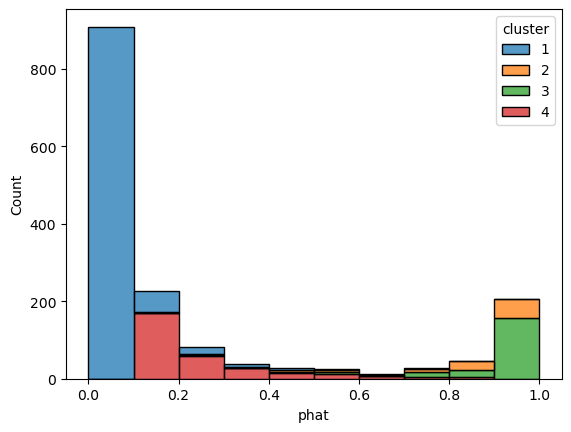

In [22]:
sns.histplot(data=plot_data, x="phat", hue="cluster", binwidth=0.1, stat="count", multiple="stack", palette=sns.color_palette("tab10", 4))
plt.show()
